In [34]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [13]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [14]:
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [17]:
## CHANGE DOWNLOAD TO TRUE, IF RUNNING FOR FIRST TIME!
voc_train = datasets.VOCSegmentation(root='./data',
                                     year='2012',
                                     image_set='train',
                                     download=True,
                                     transform=transform,
                                     target_transform=target_transform)

voc_val = datasets.VOCSegmentation(root='./data',
                                   year='2012',
                                   image_set='val',
                                   download=True,
                                   transform=transform,
                                   target_transform=target_transform)

100%|██████████| 1999639040/1999639040 [38:21<00:00, 868670.67it/s] 


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [18]:
train_loader = torch.utils.data.DataLoader(voc_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(voc_val, batch_size=16, shuffle=False)

In [19]:
def show_images_masks(images, masks, num_images=4):
    """
    This function displays images and their corresponding masks.
    :param images: batch of images
    :param masks: batch of masks
    :param num_images: number of images to display
    """
    # Set the number of images to display
    num_images = min(num_images, len(images))

    plt.figure(figsize=(10, 4 * num_images))

    for i in range(num_images):
        ax = plt.subplot(num_images, 2, 2 * i + 1)
        # Convert image tensor to numpy and normalize
        img_np = images[i].numpy().transpose((1, 2, 0))
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        plt.imshow(img_np)
        plt.title("Image")
        plt.axis("off")

        ax = plt.subplot(num_images, 2, 2 * i + 2)
        # Convert mask tensor to numpy
        mask_np = masks[i].numpy().transpose((1, 2, 0))
        plt.imshow(mask_np, cmap='gray')
        plt.title("Mask")
        plt.axis("off")

        if i == 3:
            print(np.unique(mask_np))

    plt.tight_layout()
    plt.show()

[0.         0.07450981 1.        ]


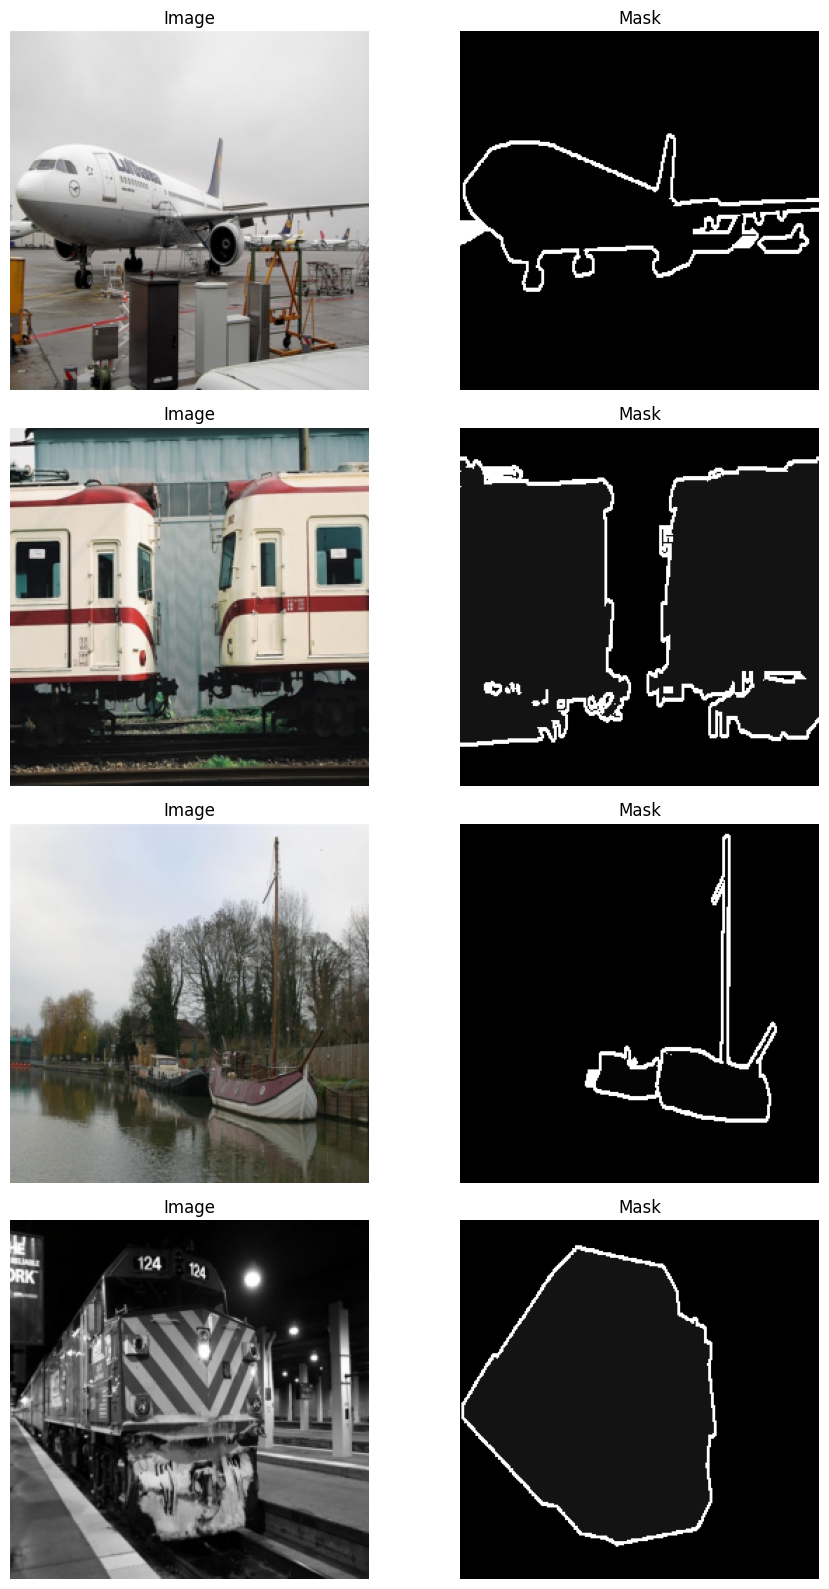

In [20]:
for imgs, masks in val_loader:
    show_images_masks(imgs, masks)
    break
## TODO: Check data integrity (visualize some samples, etc)
## TODO: ValLoader/TrainLoader
## TODO: Trainer Loops


In [37]:
from unet import UNet
def calculate_iou(outputs, labels):
    intersection = torch.logical_and(labels, outputs)
    union = torch.logical_or(labels, outputs)
    iou = torch.sum(intersection) / torch.sum(union)
    return iou.item()

In [38]:
# Define your UNet model
in_channels = 3  # Assuming RGB images
out_channels = 21  # Number of classes in Pascal VOC
channel_list = [64, 128, 256, 512]  # Adjust as needed
model = UNet(in_channels, out_channels, channel_list)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 10  # Adjust as needed
# writer = SummaryWriter()  # For TensorBoard logging
global_step = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.squeeze(1).long())  # Assuming labels are 3D (batch_size, 1, height, width)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate IoU
        outputs = torch.argmax(outputs, dim=1)
        iou = calculate_iou(outputs, labels.squeeze(1).long())
        total_iou += iou

    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_loss}, Average Training IoU: {avg_iou}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for val_images, val_labels in tqdm(val_loader, desc=f'Validation'):
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels.squeeze(1).long()).item()

            # Calculate IoU
            val_outputs = torch.argmax(val_outputs, dim=1)
            iou = calculate_iou(val_outputs, val_labels.squeeze(1).long())
            val_iou += iou

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Validation Loss: {avg_val_loss}, Average Validation IoU: {avg_val_iou}')

Epoch 1/10: 100%|██████████| 92/92 [00:55<00:00,  1.66it/s]


Epoch 1/10, Average Training Loss: 2.9658572207326475, Average Training IoU: 0.09383522706997136


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.60it/s]


Epoch 1/10, Average Validation Loss: 2.9119892696757894, Average Validation IoU: 0.11144172089112984


Epoch 2/10: 100%|██████████| 92/92 [00:55<00:00,  1.66it/s]


Epoch 2/10, Average Training Loss: 2.9107753504877505, Average Training IoU: 0.1126456983063532


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.60it/s]


Epoch 2/10, Average Validation Loss: 2.9166233251383016, Average Validation IoU: 0.12453929375816178


Epoch 3/10: 100%|██████████| 92/92 [00:55<00:00,  1.66it/s]


Epoch 3/10, Average Training Loss: 2.8645903053491013, Average Training IoU: 0.11993381721170052


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.59it/s]


Epoch 3/10, Average Validation Loss: 2.782654274950971, Average Validation IoU: 0.13762491515704564


Epoch 4/10: 100%|██████████| 92/92 [00:55<00:00,  1.66it/s]


Epoch 4/10, Average Training Loss: 2.821334551209989, Average Training IoU: 0.1241270593650963


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.59it/s]


Epoch 4/10, Average Validation Loss: 2.7860555989401683, Average Validation IoU: 0.12314844827403079


Epoch 5/10: 100%|██████████| 92/92 [00:55<00:00,  1.66it/s]


Epoch 5/10, Average Training Loss: 2.7798228393430295, Average Training IoU: 0.13038791683704956


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.57it/s]


Epoch 5/10, Average Validation Loss: 2.7045017913147644, Average Validation IoU: 0.13921825669623994


Epoch 6/10: 100%|██████████| 92/92 [00:55<00:00,  1.66it/s]


Epoch 6/10, Average Training Loss: 2.741313294224117, Average Training IoU: 0.13366684609133264


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.58it/s]


Epoch 6/10, Average Validation Loss: 2.7171413767468797, Average Validation IoU: 0.11264419465602099


Epoch 7/10: 100%|██████████| 92/92 [00:55<00:00,  1.65it/s]


Epoch 7/10, Average Training Loss: 2.7052987295648325, Average Training IoU: 0.13640626714281415


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.60it/s]


Epoch 7/10, Average Validation Loss: 2.703471052777636, Average Validation IoU: 0.12533672546947394


Epoch 8/10: 100%|██████████| 92/92 [00:55<00:00,  1.65it/s]


Epoch 8/10, Average Training Loss: 2.6712591622186745, Average Training IoU: 0.13934849599457305


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.57it/s]


Epoch 8/10, Average Validation Loss: 2.641137508245615, Average Validation IoU: 0.15205741436271877


Epoch 9/10: 100%|██████████| 92/92 [00:55<00:00,  1.65it/s]


Epoch 9/10, Average Training Loss: 2.639575756114462, Average Training IoU: 0.14262636669951936


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.58it/s]


Epoch 9/10, Average Validation Loss: 2.6647320684495863, Average Validation IoU: 0.1117058678806483


Epoch 10/10: 100%|██████████| 92/92 [00:55<00:00,  1.65it/s]


Epoch 10/10, Average Training Loss: 2.6098763424417246, Average Training IoU: 0.14645725407678148


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.53it/s]

Epoch 10/10, Average Validation Loss: 2.6352950766846375, Average Validation IoU: 0.149029950601059


In [39]:
torch.save(model.state_dict(), "models/unet_pascal_voc.pth")

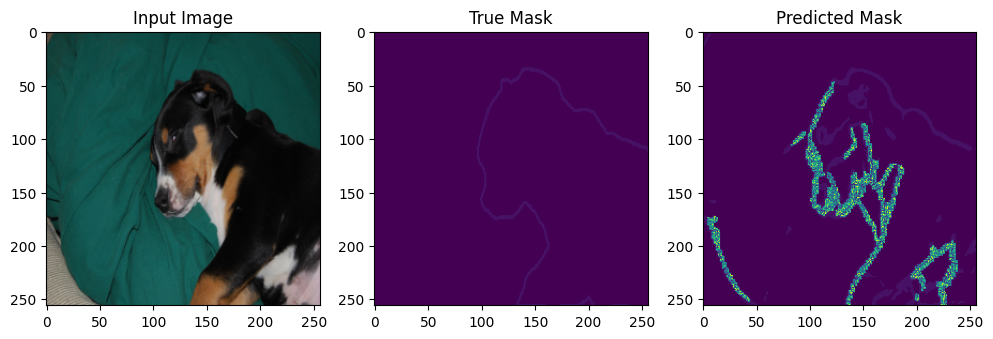

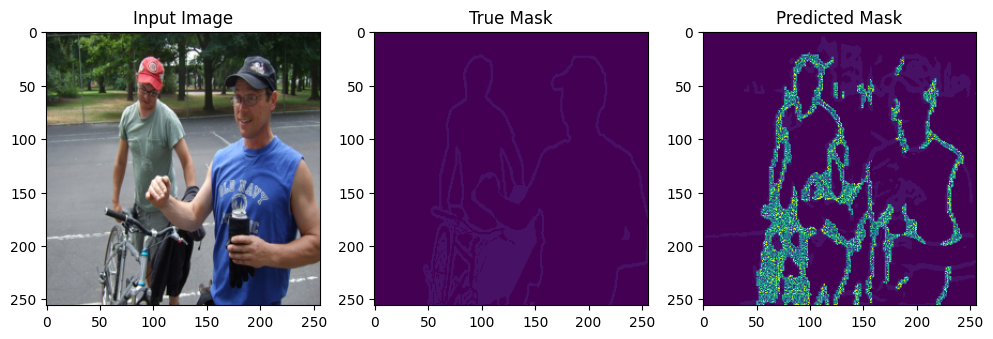

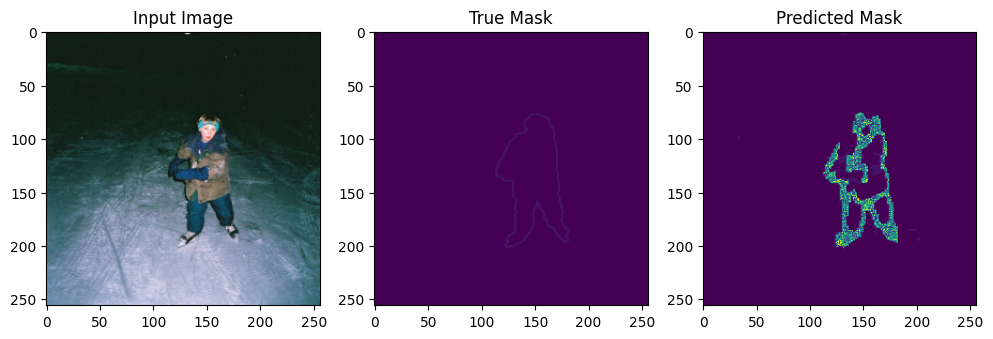

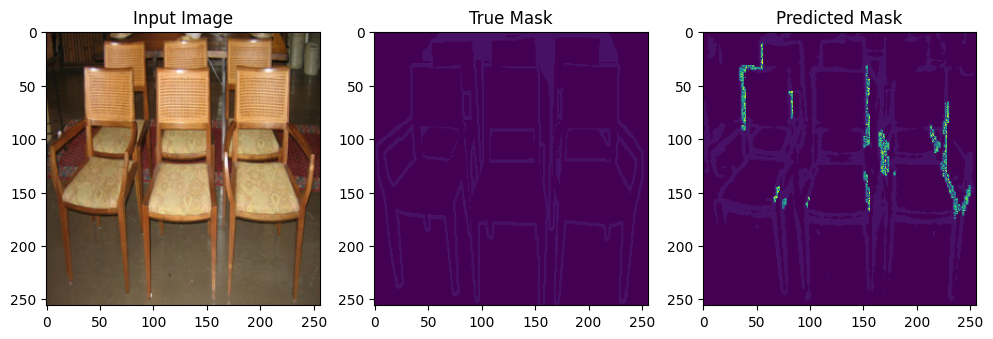

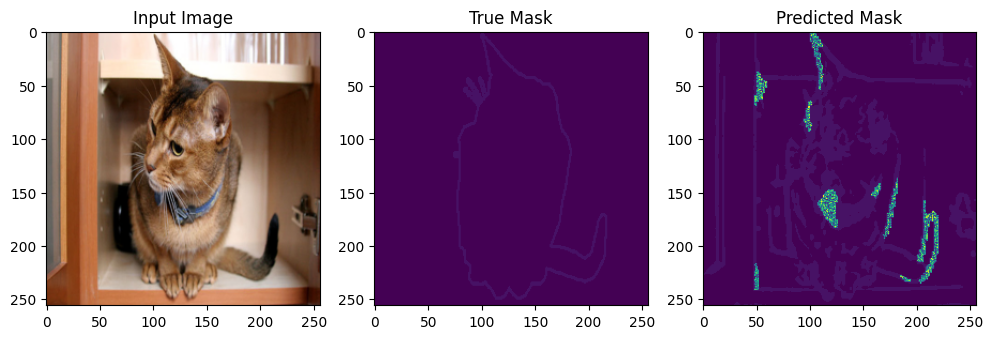

In [51]:
import torchvision.transforms.functional as TF

def inverse_normalize(image, mean, std):
    inv_normalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    )
    return inv_normalize(image)

# Set your model to evaluation mode
model.eval()

# Choose a few samples for prediction from the validation dataset
num_samples = 5
sample_loader = torch.utils.data.DataLoader(voc_val, batch_size=num_samples, shuffle=True)
sample_images, sample_labels = next(iter(sample_loader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)

# Make predictions
with torch.no_grad():
    model_outputs = model(sample_images)

# Convert predictions to class labels
_, predicted_labels = torch.max(model_outputs, 1)

for i in range(num_samples):
    # Convert tensors to numpy arrays
    input_image = inverse_normalize(sample_images[i].cpu(), mean, std).permute(1, 2, 0).numpy()
    true_mask = sample_labels[i].cpu().numpy().squeeze()  # Remove singleton dimension
    predicted_mask = predicted_labels[i].cpu().numpy().squeeze()  # Remove singleton dimension

    # Display the images and masks
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask,  vmin=0, vmax=out_channels - 1)
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, vmin=0, vmax=out_channels - 1)
    plt.title('Predicted Mask')

    plt.show()